In [2]:
import torch
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from load_LIDC_crops import LIDC_CROPS

In [3]:
print(LIDC_CROPS)
#dataset = LIDC_IDRI(dataset_location = 'data/')
dataset = LIDC_CROPS(dataset_location='lidc_crops_train/train2')

<class 'load_LIDC_crops.LIDC_CROPS'>
Start loading
316
316


100%|██████████| 316/316 [00:00<00:00, 329.55it/s]


In [4]:
dataset_size = len(dataset)
print("Number of samples: ",  dataset_size)

Number of samples:  316


In [5]:
ind = 10
img = dataset[ind][0].numpy()
label = dataset[ind][1].numpy()
print("Image properties:")
print("Class: ", type(img))
print("Dimensions of image: ", img.shape)
print("type of pixel: ", type(img[0][0][0]))

print(" ")
print("Label properties:")
print("Class: ", type(label))
print("Dimensions of label: ", label.shape)
print("type of pixel: ", type(label[0][0]))

Image properties:
Class:  <class 'numpy.ndarray'>
Dimensions of image:  (1, 128, 128)
type of pixel:  <class 'numpy.float32'>
 
Label properties:
Class:  <class 'numpy.ndarray'>
Dimensions of label:  (128, 128)
type of pixel:  <class 'numpy.float32'>


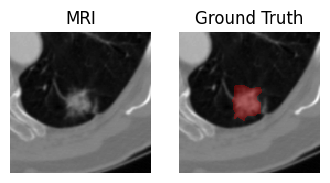

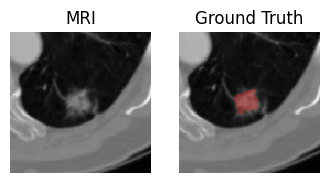

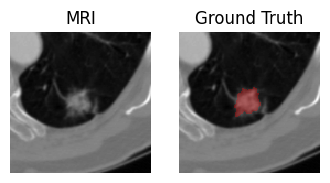

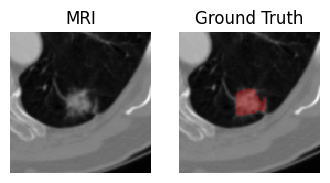

In [6]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

for i in range(4):
    ind=4+i
    img = dataset[ind][0].numpy()
    label = dataset[ind][1].numpy()
    f, axarr = plt.subplots(1, 2, figsize=(4,2))
    axarr[0].imshow(img[0, :, :], 'gray', interpolation='none', aspect=1)
    axarr[0].set_title("MRI")
    axarr[0].axis('off')

    true_color = np.zeros((label.shape[0], label.shape[1], 4), dtype='float32')
    true_color[label > 0] = (1,0,0, 0.3)

    axarr[1].imshow(img[0, :, :], 'gray', interpolation='none', aspect=1)
    axarr[1].imshow(true_color, interpolation='none', aspect=1)
    axarr[1].set_title("Ground Truth")
    axarr[1].axis('off')

(-0.5, 127.5, 127.5, -0.5)

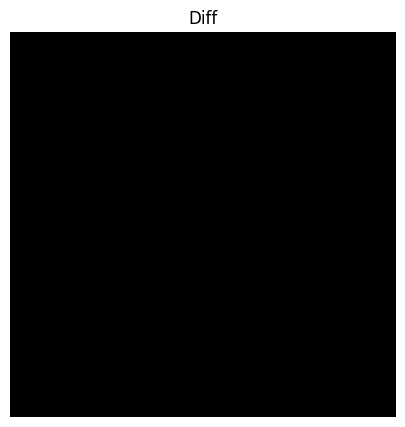

In [7]:
img_ref = dataset[0][0].numpy()
img = dataset[0][0].numpy()


diff = abs(img_ref-img)

f, axarr = plt.subplots(1, 1, figsize=(10,5))
axarr.imshow(diff[0, :, :], 'gray', interpolation='none', aspect=1)
axarr.set_title("Diff")
axarr.axis('off')

In [8]:
img_ref = dataset[0][0].numpy()
for i in range(dataset_size):
    img = dataset[i][0].numpy()
    diff = abs(img_ref-img)
    val = diff.sum()
    if (val == 0):
        print(i)

0
1
2
3


Train model

In [9]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from load_LIDC_crops import LIDC_CROPS
from probabilistic_unet import ProbabilisticUnet
import pickle
import os

Optimizer settings

In [10]:
lr = 1e-5
l2_reg = 1e-6
lr_decay_every = 5   # decay LR after this many epochs
lr_decay = 0.95

batch_size_train = 20
batch_size_val = 1
epochs = 5

In [11]:
out_dir = 'outputs/soutenance'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
else:
    print('Folder already exists. Existing models and training logs will be replaced')

Folder already exists. Existing models and training logs will be replaced


In [12]:
dataset = LIDC_CROPS(dataset_location = 'lidc_crops_train/train2')
dataset_test=LIDC_CROPS(dataset_location='lidc_crops_test/test2')
dataset_size = len(dataset)
dataset_test_size=len(dataset_test)
indices_train = list(range(dataset_size))
indices_test=list(range(dataset_test_size))
split = int(np.floor(0.1 * dataset_size))


train_indices, test_indices = indices_train, indices_test
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)
train_loader = DataLoader(dataset, batch_size=batch_size_train, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=batch_size_val, sampler=test_sampler)
print("Number of training/test patches:", (len(train_indices),len(test_indices)))

Start loading
316
316


100%|██████████| 316/316 [00:00<00:00, 837.37it/s]


Start loading
132
132


100%|██████████| 132/132 [00:00<00:00, 326.85it/s]

Number of training/test patches: (316, 132)


In [13]:
net = ProbabilisticUnet(input_channels=1, num_classes=1, num_filters=[32,64,128,192], latent_dim=2, no_convs_fcomb=4, beta=10.0)
net.cuda()

ProbabilisticUnet(
  (unet): Unet(
    (contracting_path): ModuleList(
      (0): DownConvBlock(
        (layers): Sequential(
          (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
          (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU(inplace=True)
          (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (5): ReLU(inplace=True)
        )
      )
      (1): DownConvBlock(
        (layers): Sequential(
          (0): AvgPool2d(kernel_size=2, stride=2, padding=0)
          (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): ReLU(inplace=True)
          (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (6): ReLU(inplace=True)
        )
      )
      (2): DownConvBlock(
     

In [14]:
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=l2_reg)
secheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_every, gamma=lr_decay)

In [15]:
train_loss = []
test_loss = []
best_val_loss = 999.0

In [16]:
for epoch in range(epochs):
    net.train()
    loss_train = 0
    loss_segmentation = 0
    # training loop
    for step, (patch, mask) in enumerate(train_loader): 
        patch = patch.cuda()
        mask = mask.cuda()
        mask = torch.unsqueeze(mask,1)
        net.forward(patch, mask, training=True)
        elbo = net.elbo(mask)
        loss = -elbo
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_train += loss.detach().cpu().item()
        
        if step%1==0:
            print('[Ep ', epoch+1, (step+1), ' of ', len(train_loader) ,'] train loss: ', loss_train/(step+1))
        
    # end of training loop
    loss_train /= len(train_loader)
    
    # valdiation loop
    net.eval()
    loss_val = 0
    
    with torch.no_grad():
        for step, (patch, mask) in enumerate(test_loader): 
            patch = patch.cuda()
            mask = mask.cuda()
            mask = torch.unsqueeze(mask,1)
            net.forward(patch, mask, training=True)
            elbo = net.elbo(mask)
            loss = -elbo 
            
            loss_val += loss.detach().cpu().item()
    
    
    loss_val /= len(test_loader)
    
    train_loss.append(loss_train)
    test_loss.append(loss_val)
    
    print('End of epoch ', epoch+1, ' , Train loss: ', loss_train, ', val loss: ', loss_val)   
    
    secheduler.step()
    
    # save best model checkpoint
    if loss_val < best_val_loss:
        best_val_loss = loss_val
        fname = 'model_dict.pth'
        torch.save(net.state_dict(), os.path.join(out_dir, fname))
        print('model saved at epoch: ', epoch+1)

print('Finished training')

c:\Users\b9845\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


[Ep  1 1  of  16 ] train loss:  348813.25
[Ep  1 2  of  16 ] train loss:  311624.203125
[Ep  1 3  of  16 ] train loss:  289816.765625
[Ep  1 4  of  16 ] train loss:  273577.28515625
[Ep  1 5  of  16 ] train loss:  264580.8625
[Ep  1 6  of  16 ] train loss:  257497.63541666666
[Ep  1 7  of  16 ] train loss:  251388.32589285713
[Ep  1 8  of  16 ] train loss:  246315.6640625
[Ep  1 9  of  16 ] train loss:  242207.69270833334
[Ep  1 10  of  16 ] train loss:  239319.584375
[Ep  1 11  of  16 ] train loss:  236603.41619318182
[Ep  1 12  of  16 ] train loss:  234110.328125
[Ep  1 13  of  16 ] train loss:  231949.53485576922
[Ep  1 14  of  16 ] train loss:  230438.97879464287
[Ep  1 15  of  16 ] train loss:  228771.10729166667
[Ep  1 16  of  16 ] train loss:  224461.1845703125
End of epoch  1  , Train loss:  224461.1845703125 , val loss:  10335.426336115057


KeyboardInterrupt: 

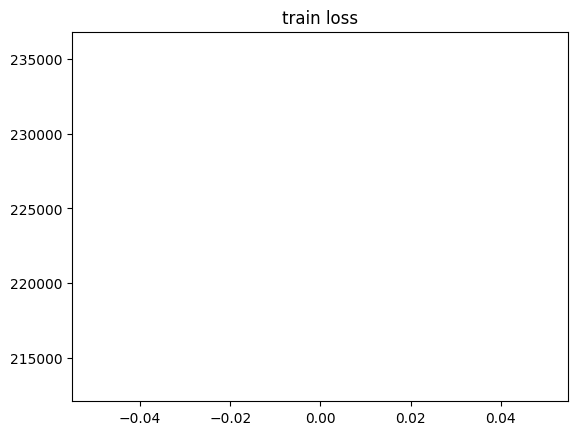

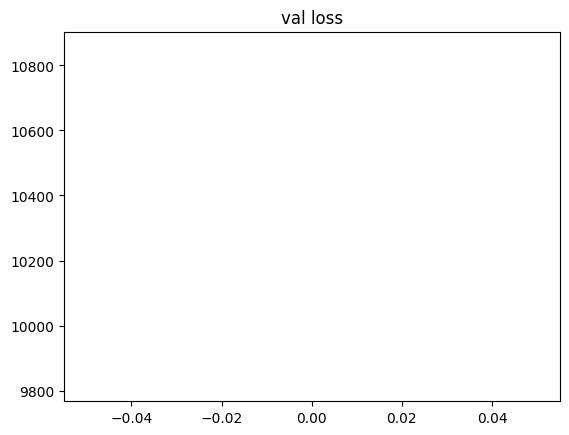

In [17]:
plt.figure()
plt.plot(train_loss)
plt.title('train loss')
fname = os.path.join(out_dir,'loss_train.png')
plt.savefig(fname)
plt.show()
plt.close()


plt.figure()
plt.plot(test_loss)
plt.title('val loss')
fname = os.path.join(out_dir,'loss_val.png')
plt.savefig(fname)
plt.show()
plt.close()


# Saving logs
log_name = os.path.join(out_dir, "logging.txt")
with open(log_name, 'w') as result_file:
    result_file.write('Logging... \n')
    result_file.write('Validation loss ')
    result_file.write(str(test_loss))
    result_file.write('\nTraining loss  ')
    result_file.write(str(train_loss))

Visualize

In [18]:
cpk_directory = 'outputs/1'     # a trained model is provided in this directory. 
print('Using the trained model from directory: ', cpk_directory)
if not os.path.exists(cpk_directory):
    raise ValueError('Please specify the out_dir in visualize.py which contains the trained model dict')

out_dir = 'outputs/soutenance'  # results will be saved in 'out_dir/visual_results'
save_dir = os.path.join(out_dir, 'visual_results')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
else:
    print('Folder already exists, overwriting previous results')

batch_size_val = 1    
save_batches_n = 1     # save this many batches
samples_per_example = 4

Using the trained model from directory:  outputs/1
Folder already exists, overwriting previous results


In [19]:
dataset = LIDC_CROPS(dataset_location = 'lidc_crops_val/val2')
dataset_size = len(dataset)
indices = list(range(dataset_size))

train_indices, test_indices = indices, indices
test_sampler = SubsetRandomSampler(test_indices)
test_loader = DataLoader(dataset, batch_size=batch_size_val, sampler=test_sampler)
print("Number of test patches:", len(test_indices))


Start loading
4
0


  0%|          | 0/4 [00:00<?, ?it/s]


IndexError: list index out of range

In [ ]:
cpk_name = os.path.join(cpk_directory, 'model_dict.pth')
net.load_state_dict(torch.load(cpk_name))
net.eval()

ProbabilisticUnet(
  (unet): Unet(
    (contracting_path): ModuleList(
      (0): DownConvBlock(
        (layers): Sequential(
          (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
          (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU(inplace=True)
          (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (5): ReLU(inplace=True)
        )
      )
      (1): DownConvBlock(
        (layers): Sequential(
          (0): AvgPool2d(kernel_size=2, stride=2, padding=0)
          (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): ReLU(inplace=True)
          (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (6): ReLU(inplace=True)
        )
      )
      (2): DownConvBlock(
     

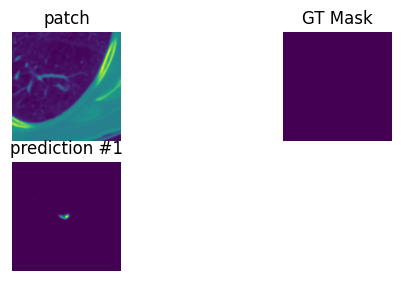

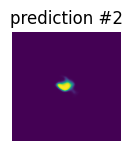

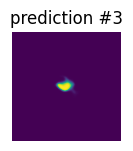

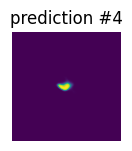

Finished saving images


In [ ]:
with torch.no_grad():
    for step, (patch, mask) in enumerate(test_loader):
        if step >= save_batches_n:
            break
        patch = patch.cuda()
        mask = mask.cuda()
        mask = torch.unsqueeze(mask,1)
        output_samples = []
        for i in range(samples_per_example):
            net.forward(patch, mask, training=True)
            output_samples.append( torch.sigmoid(net.sample()).detach().cpu().numpy() )

        for k in range(patch.shape[0]):    # for all items in batch
            patch_out = patch[k, 0, :,:].detach().cpu().numpy()
            mask_out = mask[k, 0, :,:].detach().cpu().numpy()

            plt.figure()
            
            plt.subplot(3,2,1)
            plt.imshow(patch_out)
            plt.title('patch')
            plt.axis('off')
            plt.subplot(3,2,2)
            plt.imshow(mask_out)
            plt.title('GT Mask')
            plt.axis('off')
            
            for j in range(len(output_samples)):  # for all output samples
                plt.subplot(3, 2, j+3)
                plt.imshow(output_samples[j][k, 0, :, :])
                plt.title('prediction #'+str(j+1))
                plt.axis('off')
                plt.show()
            
            fname = os.path.join(save_dir, 'result_'+str(step)+'_'+str(k)+'.png')
            plt.savefig(fname, bbox_inches='tight')
            plt.close()




print('Finished saving images')